<a href="https://colab.research.google.com/github/salujav4/Image-Classification/blob/main/Age%20group%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [80]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15347074569263102591
 xla_global_id: -1]

In [2]:
!pip install -q keras_tuner

     |████████████████████████████████| 98 kB 3.7 MB/s 


In [3]:
import numpy as np                                                ###Importing the relevant libraries
import matplotlib.pyplot as plt
import os 
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from tensorflow.keras.utils import to_categorical

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip -uq "/content/drive/My Drive/face_age.zip" -d "/content/drive/My Drive/PATH_TO_OUTPUT"

In [9]:
DATADIR = "/content/drive/My Drive/PATH_TO_OUTPUT/face_age"   
CATEGORIES = ["Group 1-2","Group 3-11","Group 12-24","Group 25-36","Group 37-55","Group Above 55"]

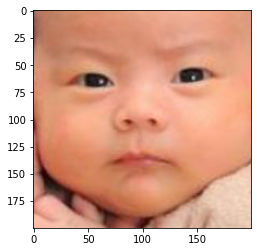

In [10]:
for category in CATEGORIES:                                                              
    path = os.path.join(DATADIR,category)                        ###Directing the path of images and plotting the sample
    for img in os.listdir(path):
        im_array = cv2.imread(os.path.join(path,img))
        img_array = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)
        plt.imshow(img_array, cmap = 'rainbow')
        plt.show
        break
    break

In [11]:
img_array.shape

(200, 200, 3)

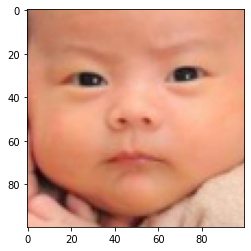

In [12]:
IMG_SIZE = 100

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))               ###Resizing the image according to the GPU
plt.imshow(new_array, cmap='gray')
plt.show()

In [13]:
training_data = []

def create_training_data():
    for category in CATEGORIES: 
        path = os.path.join(DATADIR,category)                        ###Creating training data for all 5 classes 
        class_num = CATEGORIES.index(category) 
        for img in tqdm(os.listdir(path)):  
            try:
                im_array = cv2.imread(os.path.join(path,img))  
                img_array = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE),3) 
                training_data.append([new_array, class_num])  
            except Exception as e:  
                pass
            

create_training_data()

100%|██████████| 1592/1592 [00:09<00:00, 174.38it/s]


In [14]:
len(training_data)

9452

In [15]:
import random                                       ###Shuffling the data
random.shuffle(training_data)

In [16]:
X = []
y = []                                                         ###Dividing it into features and label
for feature,label in training_data:
    X.append(feature)
    y.append(label)

In [17]:
X = np.array(X)/255                              ###Converting the arrays between 0 and 1
y = np.array(y)

In [18]:
print(X.shape, y.shape)

(9452, 100, 100, 3) (9452,)


In [19]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [20]:
x_train = x_train.reshape(-1,IMG_SIZE,IMG_SIZE,3)

In [21]:
x_test = x_test.reshape(-1,IMG_SIZE,IMG_SIZE,3)              ###Resizing(2)

In [30]:
x_train.shape

(7089, 100, 100, 3)

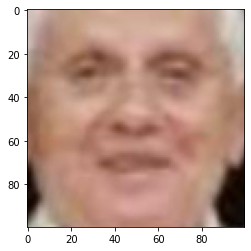

In [40]:
plt.imshow(x_train[-3])

In [22]:
y_train

array([2, 0, 4, ..., 5, 3, 2])

In [23]:
y_train = to_categorical(y_train,6)                      ###Getting shape of (,5) for labels
y_test = to_categorical(y_test,6)

In [24]:
classes = len(np.unique(y))                          

In [41]:
model = Sequential()                     ###Conv2D model
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (100,100,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(6, activation = "softmax"))

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 96)      

In [43]:
batch_size=128  ###Using More epochs due to large number of classes
epochs=25

from keras.callbacks import ReduceLROnPlateau   ###Using ReduceLROnPlateau due to the inconsistent dataset
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [44]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [45]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [46]:
model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),epochs = epochs, verbose = 1,validation_data = (x_test,y_test), steps_per_epoch=x_train.shape[0] // batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/25
55/55 [==============================] - 175s 3s/step - loss: 1.7301 - accuracy: 0.2449 - val_loss: 1.6077 - val_accuracy: 0.3191
Epoch 2/25
55/55 [==============================] - 173s 3s/step - loss: 1.6146 - accuracy: 0.3160 - val_loss: 1.4844 - val_accuracy: 0.3970
Epoch 3/25
55/55 [==============================] - 177s 3s/step - loss: 1.5160 - accuracy: 0.3741 - val_loss: 1.3588 - val_accuracy: 0.4507
Epoch 4/25
55/55 [==============================] - 173s 3s/step - loss: 1.4075 - accuracy: 0.4100 - val_loss: 1.2708 - val_accuracy: 0.4638
Epoch 5/25
55/55 [==============================] - 174s 3s/step - loss: 1.3151 - accuracy: 0.4483 - val_loss: 1.2289 - val_accuracy: 0.4888
Epoch 6/25
55/55 [==============================] - 171s 3s/step - loss: 1.2299 - accuracy: 0.4808 - val_loss: 1.1935 - val_accuracy: 0.4930
Epoch 7/25
55/55 [==============================] - 173s 3s/step - loss: 1.2290 - accuracy: 0.4844 - val_loss: 1.1034 - val_accuracy: 0.5366
Epoch 8/25
55

In [47]:
y_pred = model.predict(x_test)

In [48]:
y_pred

array([[6.2153129e-07, 2.5819449e-03, 7.3611999e-01, 2.1797118e-01,
        3.8433429e-02, 4.8928345e-03],
       [9.6890008e-01, 3.1062659e-02, 3.7144015e-05, 5.2983317e-08,
        5.1061843e-08, 1.5237201e-07],
       [6.7769998e-01, 3.1958991e-01, 2.7096844e-03, 1.5382246e-07,
        6.6113813e-08, 7.9417418e-08],
       ...,
       [1.6849567e-07, 1.5988773e-04, 1.0266742e-01, 2.7654344e-01,
        2.9667571e-01, 3.2395339e-01],
       [1.4276136e-04, 3.6477700e-02, 5.6994295e-01, 2.9216692e-01,
        7.2832152e-02, 2.8437542e-02],
       [9.6858951e-04, 8.7996262e-01, 1.1901687e-01, 4.5571775e-05,
        4.8655202e-06, 1.5860788e-06]], dtype=float32)

In [49]:
y_pred_classes = [np.argmax(element) for element in y_pred]                   ###Truncating to integers
Y_test = [np.argmax(y, axis=None, out=None) for y in y_test]
print("Classification Report: \n", classification_report(Y_test, y_pred_classes))         ###Getting the report

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.83      0.84       372
           1       0.72      0.72      0.72       415
           2       0.57      0.59      0.58       398
           3       0.54      0.52      0.53       413
           4       0.50      0.47      0.48       394
           5       0.67      0.75      0.70       371

    accuracy                           0.64      2363
   macro avg       0.64      0.65      0.64      2363
weighted avg       0.64      0.64      0.64      2363



In [50]:
y_classes = [np.argmax(element) for element in y_pred]
y_classes[:5]

[2, 0, 0, 4, 4]

In [51]:
Y_test[:5]

[3, 0, 0, 5, 2]

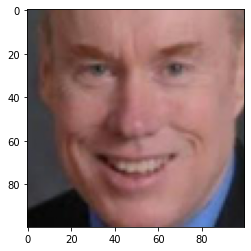

In [54]:
plt.imshow(x_test[3])

In [91]:
test = "/content/drive/My Drive/teen.jpg"

In [86]:
from PIL import Image

In [87]:
def show_img(image_link):
  img = Image.open(image_link)
  plt.imshow(img)

In [81]:
def predict(image_link):
  img = Image.open(image_link)
  test_array = np.array(img)
  new_array = cv2.resize(test_array, (IMG_SIZE, IMG_SIZE))
  new_array = new_array/255
  new_array = new_array.reshape(-1,100,100,3)
  pred = np.argmax(model.predict(new_array))
  print('He belongs to the class of: {}'.format(CATEGORIES[pred])) 

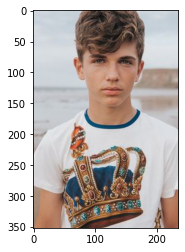

In [92]:
show_img("/content/drive/My Drive/teen.jpg")

In [93]:
predict("/content/drive/My Drive/teen.jpg")

He belongs to the class of: Group 12-24


In [94]:
model.save('model.pkb')

INFO:tensorflow:Assets written to: model.pkb/assets


In [95]:
model.save("age_detector.model",save_format="h5")